In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os

import keras
from keras.models import Model, load_model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import ModelCheckpoint

from dataloader import trainGenerator, validGenerator
from model_9_layer_GSLRE import build_model_GSLRE

/Users/lizhechen/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
rootDir='./data/image_data'
trainDir = os.path.join(rootDir, 'train')
validDir = os.path.join(rootDir, 'test')
with open('./data/char_dict', 'rb') as handler:
    charDict = pkl.load(handler)
    
with open('./data/index_key_500.pickle', 'rb') as handler:
    index_key_500 = pkl.load(handler)

classSize = 500

In [4]:
batchSize = 128
val_batchSize = 128
width, height = 96, 96

In [5]:
# vg = validGenerator(validDir, val_batchSize, 96, 96)
vg = validGenerator(validDir, val_batchSize, 96, 96, binary=True, thresh=0.99)

Found 29894 images belonging to 500 classes.


In [6]:
# tg = trainGenerator(trainDir, batchSize, 96, 96)
tg = trainGenerator(validDir, val_batchSize, 96, 96, binary=True, thresh=0.99)

Found 29894 images belonging to 500 classes.


In [8]:
model = build_model_GSLRE(classSize)
model.load_weights('model_origin_weights_best_epoch.hdf5')

In [17]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='model_origin_weights_best_epoch.hdf5',
                                               verbose = 0, save_best_only=True, monitor='val_acc')

In [18]:
for i in range(5):
    tens = i + 1
    Lrate = 0.1**tens
    print(Lrate)
    sgd = optimizers.SGD(lr=Lrate, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])
    history = model.fit_generator(tg, epochs=10, verbose=1,
                        validation_data=vg,
                        callbacks=[checkpointer])
    with open('history_epoch{}0.pickle'.format(tens), 'wb') as handler:
        pkl.dump(history.history, handler, protocol=pkl.HIGHEST_PROTOCOL)
# test_loss, test_acc = model.evaluate_generator(vg, verbose=1)

0.1


NameError: name 'tg' is not defined

In [8]:
bvg = validGenerator(validDir, val_batchSize, 96, 96, binary=True, thresh=0.99)

Found 29894 images belonging to 500 classes.


In [6]:
test_model = build_model_GSLRE(500)

test_model.load_weights('model_b0.99_weights_best_epoch.hdf5')
test_model.compile(loss='categorical_crossentropy',
        optimizer='SGD',
        metrics=['accuracy'])

test_loss, test_acc = test_model.evaluate_generator(vg, verbose=1)

234/234 [==============================] - 446s 2s/step


[[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]]
候
原
便
集
接
受
属
展


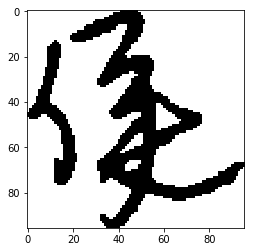

In [17]:
# test_model.compile(loss='categorical_crossentropy',
#         optimizer='SGD',
#         metrics=['accuracy'])

# test_loss, test_acc = test_model.evaluate_generator(vg, verbose=1)
sample = vg[7][0][0].reshape(1, 96, 96, 1)

print(sample[0])

result = test_model.predict(sample, batch_size=1).reshape(classSize)
# number of output
index = result.argsort()[-8:][::-1]
# dont need this one when in gui
plt.imshow(sample.reshape(96,96), cmap='gray')
# 
for i in index:
    print(index_key_500[i])

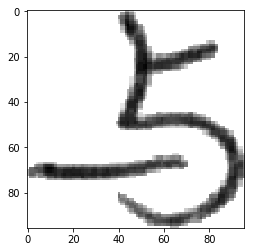

In [30]:
from scipy.ndimage import binary_dilation
temp = vg[85][0][0]
# temp = (temp - temp.min())/ np.ptp(temp)
# print(temp.min())
# plt.imshow(temp.reshape(96,96), cmap='gray')
plt.imshow(temp.reshape(96,96), cmap='gray')

In [9]:
k=4
b = 0.1**k
b

0.00010000000000000002

In [32]:
freq500Words = np.load('./data/MostFreq500inHWDB1.1.npy')

In [38]:
index_key_500 = {}
for key, value in charDict.items():
    if freq500Words[value] == 1:
        newLabel = np.int(freq500Words[:value+1].sum() - 1)
        index_key_500[newLabel] = key
with open('./data/index_key_500.pickle', 'wb') as handler:
        pkl.dump(index_key_500, handler, protocol=pkl.HIGHEST_PROTOCOL)

In [7]:
test_loss, test_acc

(0.18790950887580615, 0.9523650230177511)

In [2]:
binary_hist = './500_b0.99'
origin_hist = './500_origin'

pkl_files = ['history_epoch10.pickle', 'history_epoch20.pickle','history_epoch30.pickle',
             'history_epoch40.pickle','history_epoch50.pickle']

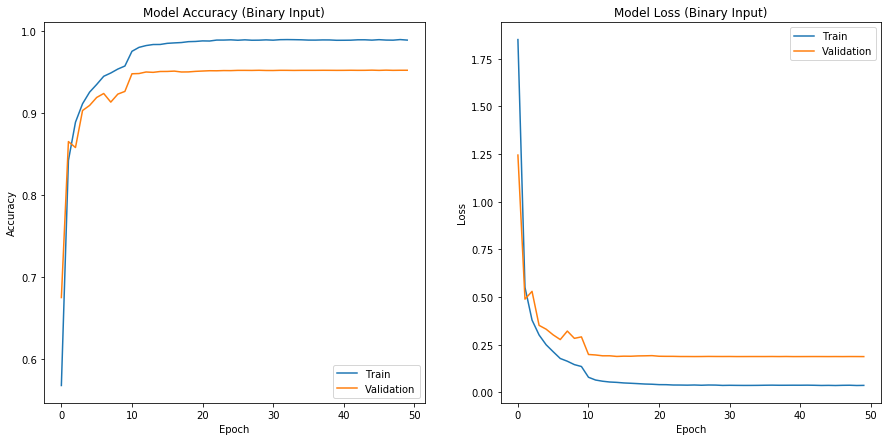

In [11]:
 
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
record = {'acc': [], 'val_acc':[], 'loss':[], 'val_loss':[]}
for h in pkl_files:
    with open(os.path.join(binary_hist, h), 'rb') as file:
        temp = pkl.load(file)
    record['acc'] += temp['acc']
    record['val_acc'] += temp['val_acc']
    record['loss'] += temp['loss']
    record['val_loss'] += temp['val_loss']

        
axes[0].plot([x for x in range(0, 50)], record['acc'])
axes[0].plot([x for x in range(0, 50)], record['val_acc'])
axes[1].plot([x for x in range(0, 50)], record['loss'])
axes[1].plot([x for x in range(0, 50)], record['val_loss'])


axes[0].set_title('Model Accuracy (Binary Input)')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='lower right')

axes[1].set_title('Model Loss (Binary Input)')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper right')

fig.savefig('history_binary_model.png', dpi='figure' )

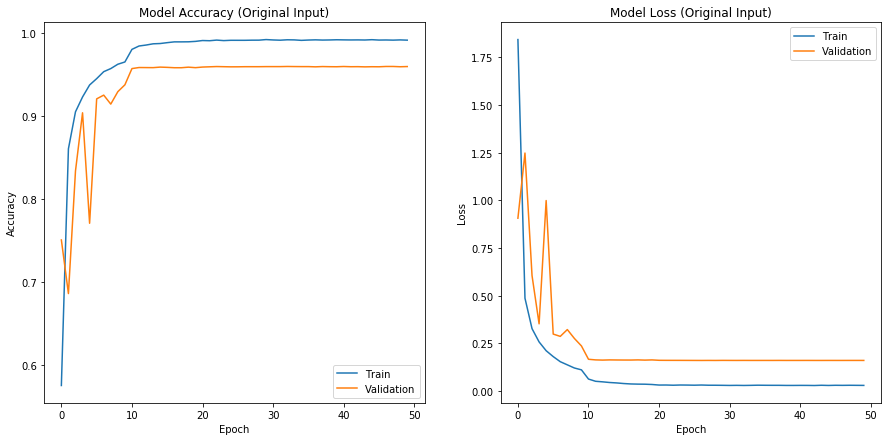

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
record = {'acc': [], 'val_acc':[], 'loss':[], 'val_loss':[]}
for h in pkl_files:
    with open(os.path.join(origin_hist, h), 'rb') as file:
        temp = pkl.load(file)
    record['acc'] += temp['acc']
    record['val_acc'] += temp['val_acc']
    record['loss'] += temp['loss']
    record['val_loss'] += temp['val_loss']

        
axes[0].plot([x for x in range(0, 50)], record['acc'])
axes[0].plot([x for x in range(0, 50)], record['val_acc'])
axes[1].plot([x for x in range(0, 50)], record['loss'])
axes[1].plot([x for x in range(0, 50)], record['val_loss'])


axes[0].set_title('Model Accuracy (Original Input)')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='lower right')

axes[1].set_title('Model Loss (Original Input)')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper right')

fig.savefig('history_origin_model.png', dpi='figure' )